## Setup
Similar to the previous projects, we will need some code to set up the environment.

First, run this cell that loads the autoreload extension. This allows us to edit .py source files and re-import them into the notebook for a seamless editing and debugging experience.


In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup

**If you are not using Colab, please just skip this step.**

Run the following cell to mount your Google Drive. Follow the link and sign in to your Google account (the same account you used to store this notebook!).

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Then enter your path of the project (for example, /content/drive/MyDrive/ConditionalDDPM)

In [3]:
# cd /content/drive/MyDrive/Graduate/ECE239_TA/ConditionalDDPM/skeleton

We will use GPUs to accelerate our computation in this notebook.

If you are using Colab, go to `Runtime > Change runtime type` and set `Hardware accelerator` to `GPU`. This will reset Colab. **Rerun the top cell to mount your Drive again.**

Run the following to make sure GPUs are enabled:

In [4]:
# set the device
import torch
device = torch.device("mps" if torch.mps.is_available() else "cpu")

if torch.mps.is_available():
  print('Good to go!')
else:
  print('Please set GPU!')

Good to go!


## Conditional Denoising Diffusion Probabilistic Models

In the lectures, we have learnt about Denoising Diffusion Probabilistic Models (DDPM), as presented in the paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf). We went through both the training process and test sampling process of DDPM. In this project, you will use conditional DDPM to generate digits based on given conditions. The project is inspired by the paper [Classifier-free Diffusion Guidance](https://arxiv.org/pdf/2207.12598.pdf), which is a following work of DDPM. You are required to use MNIST dataset and the GPU device to complete the project.


### What is a DDPM?

A Denoising Diffusion Probabilistic Model (DDPM) is a type of generative model inspired by the natural diffusion process. In the example of image generation, DDPM works in two main stages:

- Forward Process (Diffusion): It starts with an image sampled from the dataset and gradually adds noise to it step by step, until it becomes completely random noise. In implementation, the forward diffusion process is fixed to a Markov chain that gradually adds Gaussian noise to the data according to a variance schedule $\beta_1, ..., \beta_T$.

- Reverse Process (Denoising): By learning how the noise was added on the image step by step, the model can do the reverse process: start with random noise and step by step, remove this noise to generate an image.

### Training and sampling of DDPM

As proposed in the DDPM paper, the training and sampling process can be concluded in the following steps:

<!-- <img src="pics/DDPM.png" width="800" height="200"> -->

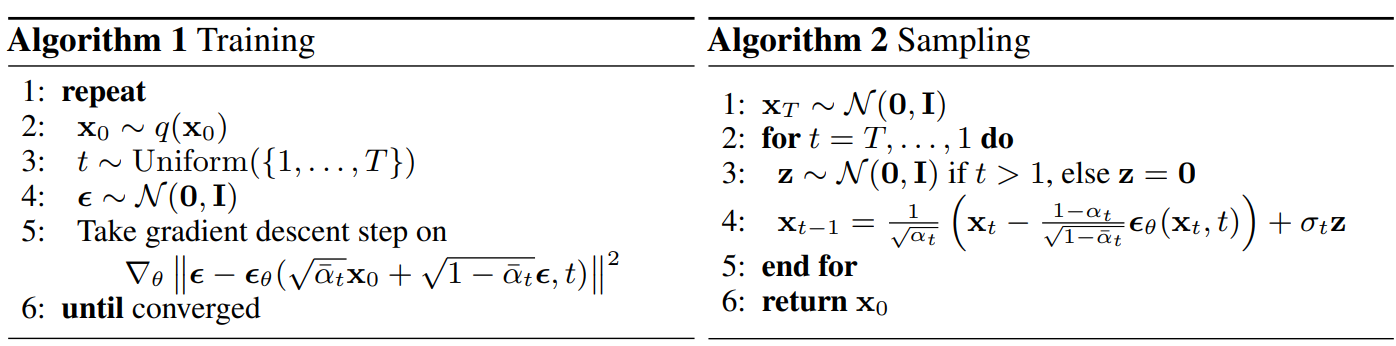

In [5]:
from IPython.display import Image
Image(filename='pics/DDPM.png', width=800, height=200)

Here we still use the example of image generation.

Algorithm 1 shows the training process of DDPM. Initially, an image $\textbf{x}_0$ is sampled from the data distribution $q(\textbf{x}_0)$, i.e. the dataset. Then a time step $t$ is randomly selected from a uniform distribution across the predifined number of steps $T$.  
A noise $\epsilon$ which has the same shape of the image is sampled from a standard normal distribution.
According to the equation (4) in the DDPM paper and the new notation: $q(\textbf{x}_t|\textbf{x}_0) = {N}(\textbf{x}_t; \sqrt{\bar{\alpha_t}}\textbf{x}_0, (1 - \bar{\alpha_t})\mathbf{I})$, $\alpha_t := 1 - \beta_t$ and $\bar{\alpha}_t := \prod_{s=1}^{t} \alpha_s$, we can get an intermediate state of the diffusion process: $\textbf{x}_t = \sqrt{\bar{\alpha_t}}\textbf{x}_0 + \sqrt{(1 - \bar{\alpha_t})}\boldsymbol{\epsilon}$.
The model takes the $\textbf{x}_t$ and $t$ as inputs, and predict a noise, i.e. $\epsilon_{\theta}(\sqrt{\bar{\alpha_t}}\textbf{x}_0 + \sqrt{(1 - \bar{\alpha_t})}\boldsymbol{\epsilon}, t)$.
The optimization of the model is done by minimizing the difference between the sampled noise and the model's prediction of noise.

Algorithm 2 shows the sampling process of DDPM, which is the complete procedure for generating an image. This process starts from noise $x_T$ sampled from a standard normal distribution, and then uses the trained model to iteratively apply denoising for each time step from $T$ to 1.

### How to control the generation output?

As you may find, the vanilla DDPM can only randomly generate images which are sampled from the learned distribution of the dataset, while in some cases, we are more interested in controlling the generated images.
Previous works mainly use an extra trained classifier to guide the diffusion model to generate specific images ([Dhariwal & Nichol (2021)](https://arxiv.org/pdf/2105.05233.pdf)).
Ho et al. proposed the [Classifier-free Diffusion Guidance](https://arxiv.org/pdf/2207.12598.pdf), which proposes a novel training and sampling method to achieve the conditional generation without extra models besides the diffusion model.
Now let's see how it modify the training and sampling pipeline of DDPM.

##### Algorithm 1: Conditional training
The training process is shown in the picture below. Some notations are modified in order to follow DDPM.

<!-- <img src="pics/ConDDPM_1.png" alt="ConDDPM_1" width="800" height="240"/> -->

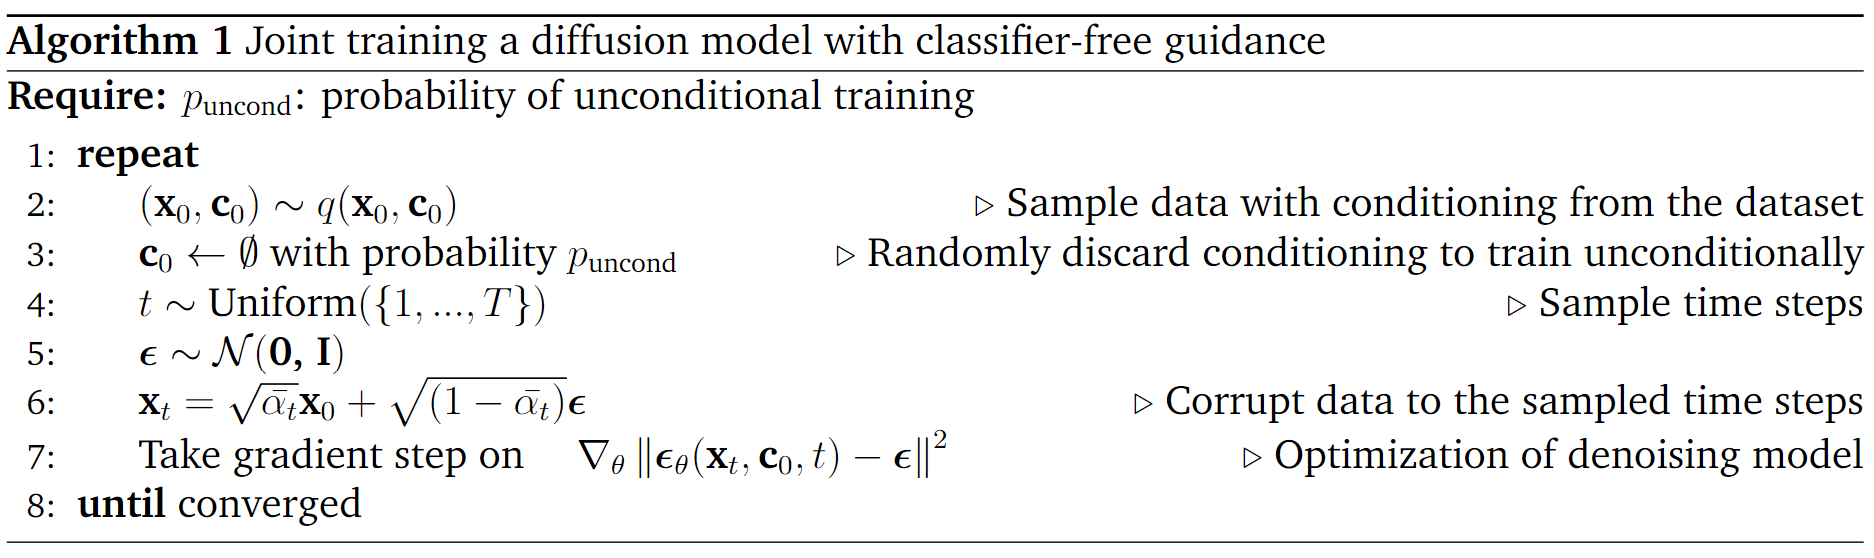

In [6]:
from IPython.display import Image
Image(filename='pics/ConDDPM_1.png', width=800, height=240)

Compared with the training process of vanilla DDPM, there are several modifications.

- In the training data sampling, besides the image $\textbf{x}_0$, we also sample the condition $\textbf{c}_0$ from the dataset (usually the class label).

- There's a probabilistic step to randomly discard the conditions, training the model to generate data both conditionally and unconditionally. Usually we just set the one-hot encoded label as all -1 to discard the conditions.

- When optimizing the model, the condition $\textbf{c}_0$ is an extra input.

##### Algorithm 2: Conditional sampling

Below is the sampling process of conditional DDPM.

<!-- <img src="pics/ConDDPM_2.png" width="500" height="250"> -->

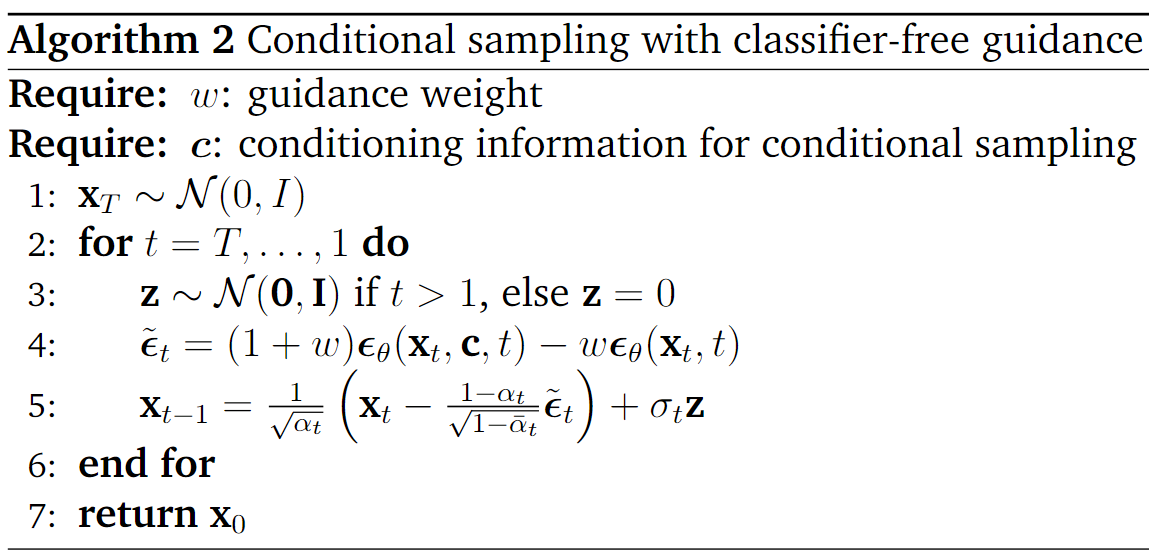

In [7]:
from IPython.display import Image
Image(filename='pics/ConDDPM_2.png', width=500, height=250)

Compared with the vanilla DDPM, the key modification is in step 4.
Here the algorithm computes a corrected noise estimation, $\tilde{\boldsymbol{\epsilon}}_t$, balancing between the conditional prediction $\boldsymbol{\epsilon}_{\theta}(\textbf{x}_t, \textbf{c}, t)$ and the unconditional prediction $\boldsymbol{\epsilon}_{\theta}(\textbf{x}_t, t)$. The corrected noise $\tilde{\boldsymbol{\epsilon}}_t$ is then used to update $\textbf{x}_t$ in step 5.

**Here we follow the setting of DDPM paper and define $\sigma_t = \sqrt{\beta_t}$.**

### Conditional generation of digits

Now let's practice it! You will first asked to design a denoising network, and then complete the training and sampling process of this conditional DDPM.

**In this project, by default, we resize all images to a dimension of $28 \times 28$ and utilize one-hot encoding for class labels. Also, please remember to normalize the time step $t$ to the range 0-1 before inputting it into the denoising network as it will help the network have a more stable output.**

First we define a configuration class `DMConfig`. This class contains all the settings of the model and experiment that may be useful later.

In [8]:
from dataclasses import dataclass, field
from typing import List, Tuple
@dataclass
class DMConfig:
    '''
    Define the model and experiment settings here
    '''
    input_dim: Tuple[int, int] = (28, 28) # input image size
    num_channels: int = 1                 # input image channels
    condition_mask_value: int = -1        # unconditional condition mask value
    num_classes: int = 10                 # number of classes in the dataset
    T: int = 400                          # diffusion and denoising steps
    beta_1: float = 1e-4                  # variance schedule
    beta_T: float = 2e-2
    mask_p: float = 0.1                   # condition drop ratio
    num_feat: int = 64                   # basic feature size of the UNet model
    omega: float = 2.0                    # conditional guidance weight

    batch_size: int = 256                 # training batch size
    epochs: int = 10                      # training epochs
    learning_rate: float = 1e-4           # training learning rate
    multi_lr_milestones: List[int] = field(default_factory=lambda: [20]) # learning rate decay milestone
    multi_lr_gamma: float = 0.1           # learning rate decay ratio

Then let's prepare and visualize the dataset:

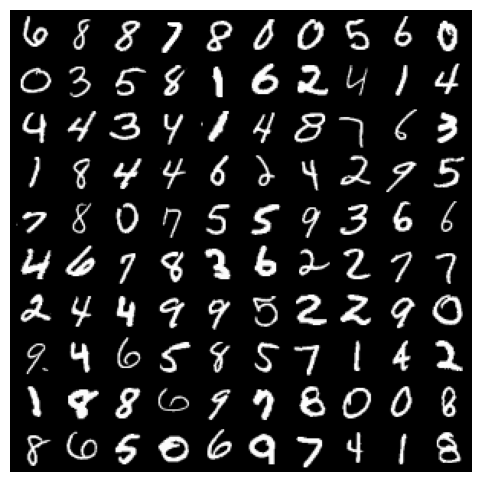

In [9]:
from utils import make_dataloader
from torchvision import transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Define the data preprocessing and configuration
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
config = DMConfig()

# Create the train and test dataloaders
train_loader = make_dataloader(transform = transform, batch_size = config.batch_size, dir = './data', train = True)
test_loader = make_dataloader(transform = transform, batch_size = config.batch_size, dir = './data', train = False)

# Visualize the first 100 images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images_subset = images[:100]
grid = vutils.make_grid(images_subset, nrow = 10, normalize = True, padding=2)
plt.figure(figsize=(6, 6))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()

#### 1. Denoising network (6 points)

The denoising network is defined in the file `ResUNet.py`. We have already provided some potentially useful layers or blocks, and you will be asked to complete the class `ConditionalUnet`.

Some hints:

- Please consider just using 2 down blocks and 2 up blocks. Using more blocks may improve the performance, while the training and sampling time may increase. Feel free to do some extra experiments in the creative exploring part later.

- An example structure of Conditional UNet is shown in the next cell. Here the initialization argument `n_feat` is set as 128. We provide all the potential useful components in the `__init__` function. The simplest way to construct the network is to complete the `forward` function with these components.


- **MODEL DESIGNING IS AN ART: You do not have to use this given structure. You can add/delete any blocks, or even design your own network from scratch. You are also free to change the way of adding the time step and condition.**



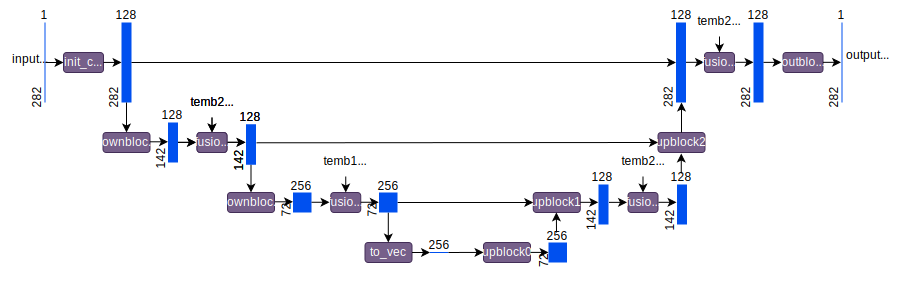

In [10]:
# Example structure of Conditional UNet
from IPython.core.display import SVG
SVG(filename='./pics/ConUNet.svg')

Now let's check your denoising network using the following code.

In [11]:
from ResUNet import ConditionalUnet
import torch
model = ConditionalUnet(in_channels = 1, n_feat = 128, n_classes = 10).to(device)
x = torch.randn((256,1,28,28)).to(device)
t = torch.randn((256,1,1,1)).to(device)
c = torch.randn((256,10)).to(device)
x_out = model(x,t,c)
assert x_out.shape == (256,1,28,28)
print('Output shape:', model(x,t,c).shape)
print('Dimension test passed!')

Output shape: torch.Size([256, 1, 28, 28])
Dimension test passed!


#### 2. Conditional DDPM

With the correct denoising network, we can then start to build the pipeline of a conditional DDPM.
You will be asked to complete the `ConditionalDDPM` class in the file `DDPM.py`.

##### 2.1 Variance schedule (4 points)

Let's first prepare the variance schedule $\beta_t$ along with other potentially useful constants.
You are required to complete the `ConditionalDDPM.scheduler` function in `DDPM.py`.

Given the starting and ending variances $\beta_1$ and $\beta_T$, the function should output one dictionary containing the following terms:

`beta_t`: variance of time step $t_s$, which is linearly interpolated between $\beta_1$ and $\beta_T$.

`sqrt_beta_t`: $\sqrt{\beta_t}$

`alpha_t`: $\alpha_t = 1 - \beta_t$

`oneover_sqrt_alpha`: $\frac{1}{\sqrt{\alpha_t}}$

`alpha_t_bar`: $\bar{\alpha_t} = \prod_{s=1}^{t} \alpha_s$

`sqrt_alpha_bar`: $\sqrt{\bar{\alpha_t}}$

`sqrt_oneminus_alpha_bar`: $\sqrt{1 - \bar{\alpha_t}}$

We set $\beta_1 = 1e-4$ and $\beta_T = 2e-2$. Let's check your solution!

In [12]:
from DDPM import ConditionalDDPM
torch.set_printoptions(precision=8)
config = DMConfig(beta_1 = 1e-4, beta_T = 2e-2)
ConDDPM = ConditionalDDPM(dmconfig = config)
schedule_dict = ConDDPM.scheduler(t_s = torch.tensor(77)) # We use a specific time step (77) to check your output
assert abs(schedule_dict['beta_t'] - 0.003890) <= 5e-6
assert abs(schedule_dict['sqrt_beta_t'] - 0.062374) <= 5e-6
assert abs(schedule_dict['alpha_t'] - 0.996110) <= 5e-6
assert abs(schedule_dict['oneover_sqrt_alpha'] - 1.001951) <= 5e-6
assert abs(schedule_dict['alpha_t_bar'] - 0.857414) <= 5e-6
assert abs(schedule_dict['sqrt_oneminus_alpha_bar'] - 0.377606) <= 5e-6
print('All tests passed!')

All tests passed!


##### 2.2 Training process (6 points)

Recall the training algorithm we discussed above:

<!-- <img src="pics/ConDDPM_1.png" alt="ConDDPM_1" width="800" height="240"/> -->

You will need to complete the  `ConditionalDDPM.forward` function in the `DDPM.py` file. Then you can use the function `utils.check_forward` to test if it's working properly. The model will be trained for one epoch in this checking process. It should take around 1 min and return one curve showing a decreasing loss trend if your `ConditionalDDPM.forward` function is correct.

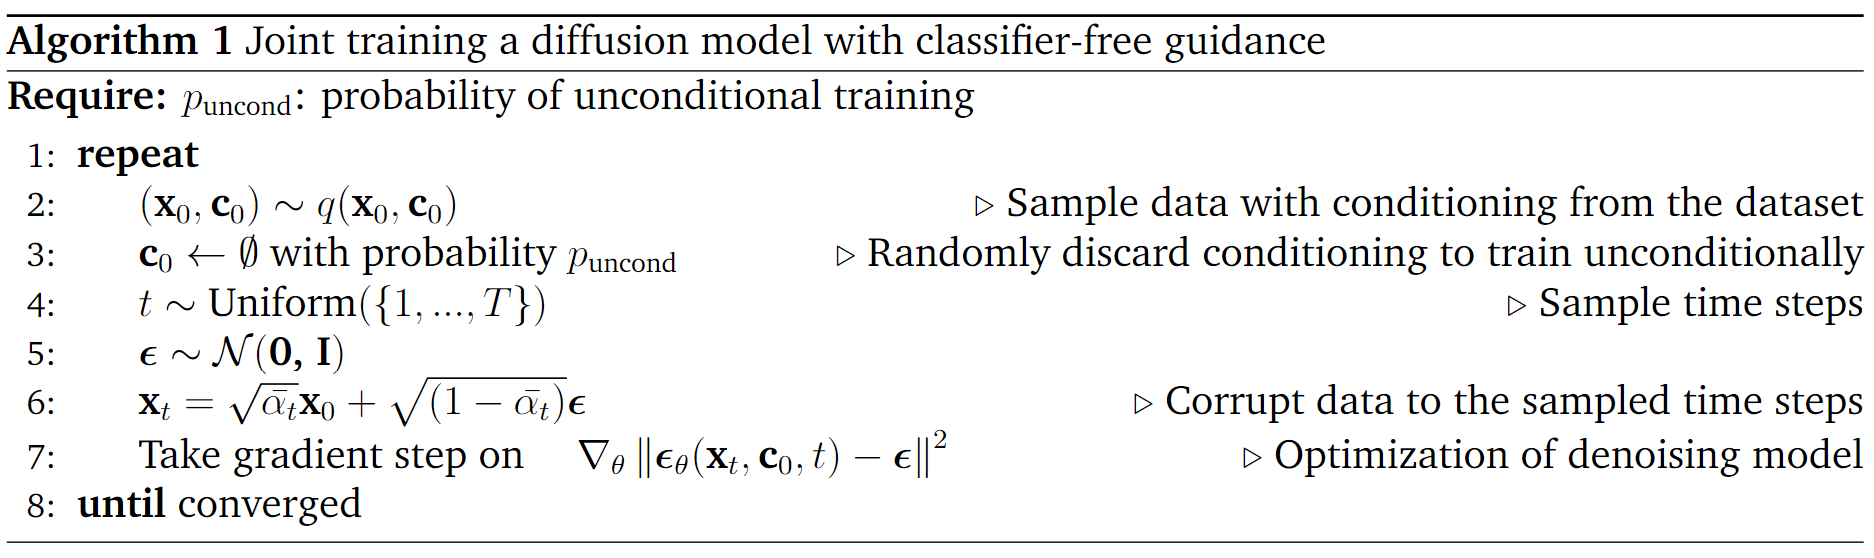

In [13]:
from IPython.display import Image
Image(filename='pics/ConDDPM_1.png', width=800, height=240)

In [15]:
from utils import check_forward
config = DMConfig()
model = check_forward(train_loader, config, device)

RuntimeError: Tensor for argument input is on cpu but expected on mps

2.3 Sampling process (6 points)

Now you are required to complete the `ConditionalDDPM.sample` function using the sampling process we mentioned above.

<!-- <img src="pics/ConDDPM_2.png" width="500" height="250"> -->

In the following cell, we will use the given `utils.check_sample` function to check the correctness. With the trained model in 2.2, the model should be able to generate some super-rough digits (you may not even see them as digits). The sampling process should take around 30s.

In [ ]:
from IPython.display import Image
Image(filename='pics/ConDDPM_2.png', width=500, height=250)

In [ ]:
from utils import check_sample
config = DMConfig()
fig = check_sample(model, config, device)

##### 2.4 Full training (8 points)

As you might notice, the images generated are imperfect since the model trained for only one epoch has not yet converged. To improve the performance, we should proceed with a complete cycle of training and testing. You can utilize a provided `solver` function in this part.

Let's refresh all configurations:

In [ ]:
train_config = DMConfig()
print(train_config)

Then we can use function `utils.solver` to train the model. You should also input your own experiment name, e.g. `your_exp_name`. The best-trained model will be saved as `./save/your_exp_name/best_checkpoint.pth`. Furthermore, for each training epoch, one generated image will be stored in the directory `./save/your_exp_name/images` as a validation.


**It will take about 10\~20 minutes (10 epochs) if you are using the free-version Google Colab GPU. Typically, realistic digits can be generated after around 2\~5 epochs.**

In [ ]:
from utils import solver
solver(dmconfig = train_config,
       exp_name = 'your_exp_name',
       train_loader = train_loader,
       test_loader = test_loader)

**Now please show the image that you believe has the best generation quality in the following cell.**

In [ ]:
# ==================================================== #
# YOUR CODE HERE:
#   Among all images generated in the experiment,
#   show the image that you believe has the best quality.
#   You may use tools like matplotlib, PIL, OpenCV, ...





# ==================================================== #

##### 2.5 Exploring the conditional guidance weight (3 points)

The generated images from the previous training-sampling process is using the default conditional guidance weight $\omega=2$. Now with the best checkpoint, please try at least 3 different $\omega$ values and visualize the generated images. You can use the provided function `sample_images` to get a combined image each time.

In [ ]:
from utils import sample_images
import matplotlib.pyplot as plt
# ==================================================== #
# YOUR CODE HERE:
#   Try at least 3 different conditional guidance weights and visualize it.
#   Example of using a different omega value:
#       sample_config = DMConfig(omega = ?)
#       fig = sample_images(config = sample_config, checkpoint_path = path_to_your_checkpoint)


# ==================================================== #

**Inline Question: Based on your experiment, discuss how the conditional guidance weight affects the quality and diversity of generation. (1 point)**

Your answer:


##### 2.6 Customize your own model (5 points)

Now let's experiment by modifying some hyperparameters in the config and costomizing your own model. You should at least change one defalut setting in the config and train a new model. Then visualize the generation image and discuss the effects of your modifications.

**Hint: Possible changes to the configuration include, but are not limited to,  the number of diffusion steps `T`, the unconditional condition drop ratio `mask_p`, the feature size `num_feat`, the beta schedule, etc.**

First you should define and print your modified config. Please state all the changes you made to the DMConfig class, i.e. `DMConfig(T=?, num_feat=?, ...)`.

In [ ]:
train_config_new = DMConfig()
print(train_config_new)

Then similar to 2.4, use `solver` funtion to complete the training and sampling process.

In [ ]:
from utils import solver
solver(dmconfig = train_config_new,
       exp_name = 'your_exp_name_new',
       train_loader = train_loader,
       test_loader = test_loader)

Finally, show one image that you think has the best quality.

In [ ]:
# ==================================================== #
# YOUR CODE HERE:
#   Among all images generated in the experiment,
#   show the image that you believe has the best generation quality.
#   You may use tools like matplotlib, PIL, OpenCV, ...





# ==================================================== #

**Inline Question: Discuss the effects of your modifications after you compare the generation performance under different configurations. (1 point)**

Your answer: